<h1> Basic feature engineering for time series forecasting <h1>

<h2> Preparing data <h2>

In [49]:
import pandas as pd

In [50]:
#read the csv data file into a pandas series:
series = pd.read_csv("daily-minimum-temperatures.csv", index_col=0, parse_dates=True, squeeze=True)
series.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

In [51]:
# convert from pandas series to pandas DataFrame:
dataframe = pd.DataFrame()
dataframe["month"] = [series.index[i].month for i in range(len(series))]
dataframe["day"] = [series.index[i].day for i in range(len(series))]
dataframe['temperature'] = [series[i] for i in range(len(series))]
dataframe.head()

,month,day,temperature
0,1,1,20.7
1,1,2,17.9
2,1,3,18.8
3,1,4,14.6
4,1,5,15.8


<h2>Lag features<h2>

Transform time series forecasting problems into supervised learning problems, by predict Value(t+1) given the value at the previous time Value(t-1)

```shift()``` is a method for pandas dataframe, that can create these shifted or lag features from a time series dataset




In [52]:
temps = pd.DataFrame(series.values)
# "shift()" is a method for pandas dataframe, that can create these shifted or lag features from a time series dataset
dataframe_shift = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe_shift.columns = ['t-3','t-2','t-1', 't']
dataframe_shift.head()


,t-3,t-2,t-1,t
0,NaN,NaN,NaN,20.7
1,NaN,NaN,20.7,17.9
2,NaN,20.7,17.9,18.8
3,20.7,17.9,18.8,14.6
4,17.9,18.8,14.6,15.8


<h2>Rolling Window Statistics<h2>

How to gather statistics of n values before values(t)?

```rolling()``` method creates a new data structure with the window of values at each time step:

In [53]:
shifted = temps.shift(1)

# "rolling()" method creates a new data structure with the window of values at each time step:
window = shifted.rolling(window=3) # calculate the statistic of three time periods
# we can then calculate different statistics with the window object:
dataframe_rolling2 = pd.concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe_rolling2.columns = ["Min", "Mean", "Max", "t"]
print(dataframe_rolling2.head(9))




    Min       Mean   Max     t
0   NaN        NaN   NaN  20.7
1   NaN        NaN   NaN  17.9
2   NaN        NaN   NaN  18.8
3  17.9  19.133333  20.7  14.6
4  14.6  17.100000  18.8  15.8
5  14.6  16.400000  18.8  15.8
6  14.6  15.400000  15.8  15.8
7  15.8  15.800000  15.8  17.4
8  15.8  16.333333  17.4  21.8


<h2>Expanding Window Statistics<h2>

An Expanding window is another type of window that may be useful includes all previous data in the series

The ```expanding()``` method help collects sets of all prior values for each time step

In [54]:
# the "expanding()" method help collects sets of all prior values for each time step
expanding_window = temps.expanding()
dataframe_expanding = pd.concat([expanding_window.min(), expanding_window.mean(), expanding_window.max(), temps.shift(-1)], axis=1)
dataframe_expanding.columns = ["min", "mean", "max", "t"]
dataframe_expanding.head(7)

,min,mean,max,t
0,20.7,20.700000,20.7,17.9
1,17.9,19.300000,20.7,18.8
2,17.9,19.133333,20.7,14.6
3,14.6,18.000000,20.7,15.8
4,14.6,17.560000,20.7,15.8
5,14.6,17.266667,20.7,15.8
6,14.6,17.057143,20.7,17.4


<h1> Training models <h1>

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<h2> Data set <h2>

In [56]:
# lag features:
temps = pd.DataFrame(series.values)
dataframe_shift = pd.concat([temps.shift(1), temps], axis=1)
dataframe_shift.columns = ['t-1', 't']
print(dataframe_shift.head())

X1 = pd.DataFrame(dataframe_shift['t-1'][1:])
y1 = pd.DataFrame(dataframe_shift['t'][1:])

print("\nX1: \n", X1.head())
print("\ny1: \n", y1.head())

# train test split:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.6, random_state=1)




    t-1     t
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8

X1: 
     t-1
1  20.7
2  17.9
3  18.8
4  14.6
5  15.8

y1: 
       t
1  17.9
2  18.8
3  14.6
4  15.8
5  15.8


In [57]:
# rolling mean:
window = shifted.rolling(window=3)
dataframe_rolling = pd.concat([window.mean(),temps], axis=1)
dataframe_rolling.columns = ["Mean", "t"]
print(dataframe_rolling.head(9))

X2 = pd.DataFrame(dataframe_rolling['Mean'][3:])
y2 = pd.DataFrame(dataframe_rolling['t'][3:])

print("\nX2: \n", X2.head())
print("\ny2: \n", y2.head())

# train test split:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.6, random_state=1)

        Mean     t
0        NaN  20.7
1        NaN  17.9
2        NaN  18.8
3  19.133333  14.6
4  17.100000  15.8
5  16.400000  15.8
6  15.400000  15.8
7  15.800000  17.4
8  16.333333  21.8

X2: 
         Mean
3  19.133333
4  17.100000
5  16.400000
6  15.400000
7  15.800000

y2: 
       t
3  14.6
4  15.8
5  15.8
6  15.8
7  17.4


In [70]:
# expanding mean:
expanding_window = temps.expanding()
dataframe_expanding = pd.concat([expanding_window.mean(), temps.shift(-1)], axis=1)
dataframe_expanding.columns = ["Mean", "t"]
print(dataframe_expanding.head())

 # expanding window will have NaN as last element
X3 = pd.DataFrame(dataframe_expanding['Mean'][:-1])
y3 = pd.DataFrame(dataframe_expanding['t'][:-1])

# train test split:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size=0.6, random_state=1)







        Mean     t
0  20.700000  17.9
1  19.300000  18.8
2  19.133333  14.6
3  18.000000  15.8
4  17.560000  15.8
          t
0     False
1     False
2     False
3     False
4     False
...     ...
3644  False
3645  False
3646  False
3647  False
3648  False

[3649 rows x 1 columns]


<h2> Linear Regression <h2>

In [72]:
from sklearn.linear_model import LinearRegression

# Model for lag feature
ln_shift = LinearRegression().fit(X1_train, y1_train)
y1_pred = ln_shift.predict(X1_test)
ln_shift_accuracy = mean_squared_error(y1_test, y1_pred)

# Model for rolling feature
ln_rolling = LinearRegression().fit(X2_train, y2_train)
y2_pred = ln_rolling.predict(X2_test)
ln_rolling_accuracy = mean_squared_error(y2_test, y2_pred)

# Model for expanding feature:
ln_expanding = LinearRegression().fit(X3_train, y3_train)
y3_pred = ln_expanding.predict(X3_test)
ln_expanding_accuracy = mean_squared_error(y3_test, y3_pred)



<h2> K-nearest neighbors <h2>

In [73]:
from sklearn.neighbors import KNeighborsRegressor

# Model for lag feature:
knn_shift = KNeighborsRegressor().fit(X1_train, y1_train)
y1_pred = knn_shift.predict(X1_test)
knn_shift_accuracy = mean_squared_error(y1_test, y1_pred)

# Model for rolling feature:
knn_rolling = KNeighborsRegressor().fit(X2_train, y2_train)
y2_pred = knn_rolling.predict(X2_test)
knn_rolling_accuracy = mean_squared_error(y2_test, y2_pred)

# Model for expanding feature:
knn_expanding = KNeighborsRegressor().fit(X3_train, y3_train)
y3_pred = knn_expanding.predict(X3_test)
knn_expanding_accuracy = mean_squared_error(y3_test, y3_pred)

<h2> Comparison <h2>

<function matplotlib.pyplot.show(close=None, block=None)>

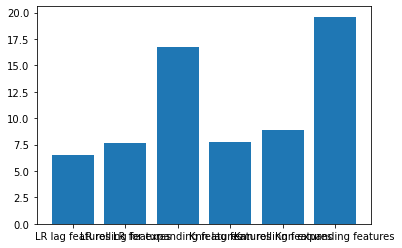

In [76]:
import matplotlib.pyplot as plt

data_labels = ['LR lag features',
                'LR rolling features',
                'LR for expanding features',
                'Knn lag features',
                'Knn rolling features',
                'Knn expanding features']

accuracy_values = [ln_shift_accuracy, ln_rolling_accuracy, ln_expanding_accuracy, knn_shift_accuracy, knn_rolling_accuracy, knn_expanding_accuracy]

plt.bar(x = data_labels, height=accuracy_values)
plt.show


So Expanding windows statistic is the best way of feature engineering for times series dataset. 
For this dataset, the K-nearest neighbors models have better result than Linear regression models